In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import glob
import os
import random
import tqdm

In [81]:
class SkyMapDataset(Dataset):
    def __init__(self, isotropic_files, hotspot_files):
        super().__init__()
        
        # Load isotropic data
        self.isotropic_data = np.concatenate([np.load(f) for f in isotropic_files], axis=0)  # (N_isotropic, 768)

        # Load hotspot data
        hotspot_arrays = []
        for f in hotspot_files:
            data = np.load(f)  # (768, N_samples, 768)
            data = data.reshape(data.shape[0] * data.shape[1], -1)  # Flatten each (768 * Nsamples, 768)
            hotspot_arrays.append(data)
        self.hotspot_data = np.concatenate(hotspot_arrays, axis=0)

        # Sanity check: print sizes
        print(f"Loaded {self.isotropic_data.shape[0]} isotropic examples.")
        print(f"Loaded {self.hotspot_data.shape[0]} hotspot examples.")

        # Find the feature dimensions
        self.isotropic_dim = self.isotropic_data.shape[1]
        self.hotspot_dim = self.hotspot_data.shape[1]
        self.compute_statistics()
        
        # Normalize the data
        self.isotropic_data = (self.isotropic_data - self.isotropic_mean) / self.isotropic_std
        self.hotspot_data = (self.hotspot_data - self.isotropic_mean) / self.isotropic_std

    def compute_statistics(self):
        # Compute mean and std for isotropic data
        self.isotropic_mean = np.mean(self.isotropic_data)
        self.isotropic_std = np.std(self.isotropic_data)

        # Compute mean and std for hotspot data
        self.hotspot_mean = np.mean(self.hotspot_data)
        self.hotspot_std = np.std(self.hotspot_data)

        print(f"Isotropic mean: {self.isotropic_mean}")
        print(f"Isotropic std: {self.isotropic_std}")
        print(f"Hotspot mean: {self.hotspot_mean}")
        print(f"Hotspot std: {self.hotspot_std}")

    def __len__(self):
        # Define length as the number of batches we can create
        return min(len(self.isotropic_data), len(self.hotspot_data)) * 2

    def __getitem__(self, idx):
        # Alternate between isotropic and hotspot
        if idx % 2 == 0:
            # Isotropic example
            i = random.randint(0, len(self.isotropic_data) - 1)
            x = self.isotropic_data[i]
            label = 0
        else:
            # Hotspot example
            i = random.randint(0, len(self.hotspot_data) - 1)
            x = self.hotspot_data[i]
            label = 1
        
        x = torch.tensor(x, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        
        return x, label

def get_dataloader(isotropic_files, hotspot_files, batch_size=32, shuffle=True):
    dataset = SkyMapDataset(isotropic_files, hotspot_files)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [ ]:
train_dataloader = get_dataloader(
    isotropic_files=[glob.glob("/path/to/skymaps/isotropic/*.npy")[0]],
    hotspot_files=[glob.glob("/path/to/skymaps/hotspot/*.npy")[0]],
    batch_size=32,
    shuffle=False
)

val_dataloader = get_dataloader(
    isotropic_files=[glob.glob(r"/Users/james/Dropbox/JimDex/40-49 Research Projects/43 Data/43.39 ml4pta/skymaps/isotropic/*.npy")[1]],
    hotspot_files=[glob.glob(r"/Users/james/Dropbox/JimDex/40-49 Research Projects/43 Data/43.39 ml4pta/skymaps/hotspot/*.npy")[1]],
    batch_size=32,
    shuffle=False
)

Loaded 200000 isotropic examples.
Loaded 384000 hotspot examples.
Isotropic mean: 265.0535888671875
Isotropic std: 307.6771545410156
Hotspot mean: 267.77655029296875
Hotspot std: 332.72186279296875
Loaded 200000 isotropic examples.
Loaded 384000 hotspot examples.
Isotropic mean: 265.72552490234375
Isotropic std: 307.89166259765625
Hotspot mean: 279.9351828373721
Hotspot std: 330.8366481465107


<Figure size 1000x500 with 0 Axes>

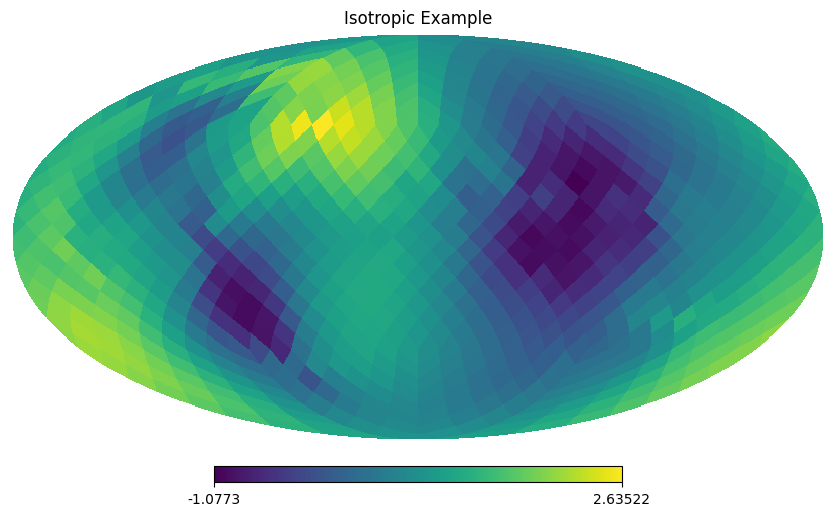

<Figure size 1000x500 with 0 Axes>

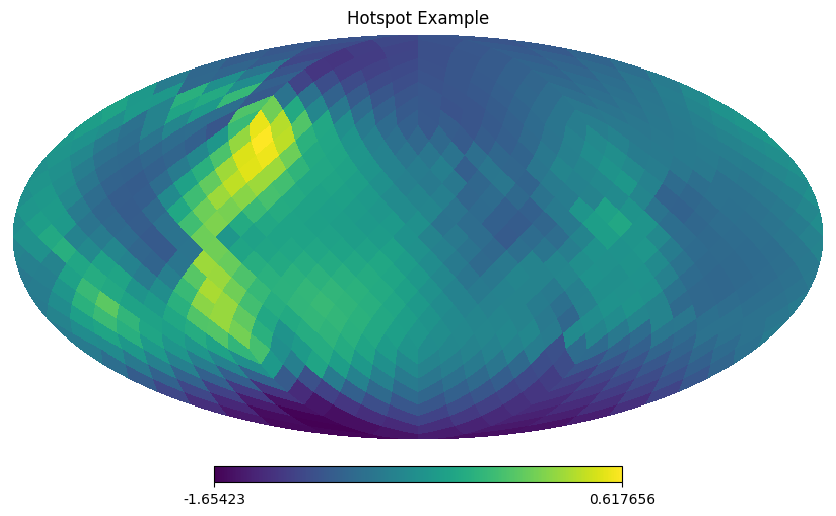

In [83]:
import healpy as hp

example_isotropic = train_dataloader.dataset.isotropic_data[np.random.randint(0, len(train_dataloader.dataset.isotropic_data))]
example_hotspot = train_dataloader.dataset.hotspot_data[np.random.randint(0, len(train_dataloader.dataset.hotspot_data))]

# Plotting the isotropic example
plt.figure(figsize=(10, 5))
hp.mollview(example_isotropic, title="Isotropic Example", cmap="viridis")
plt.show()

# Plotting the isotropic example
plt.figure(figsize=(10, 5))
hp.mollview(example_hotspot, title="Hotspot Example", cmap="viridis")
plt.show()

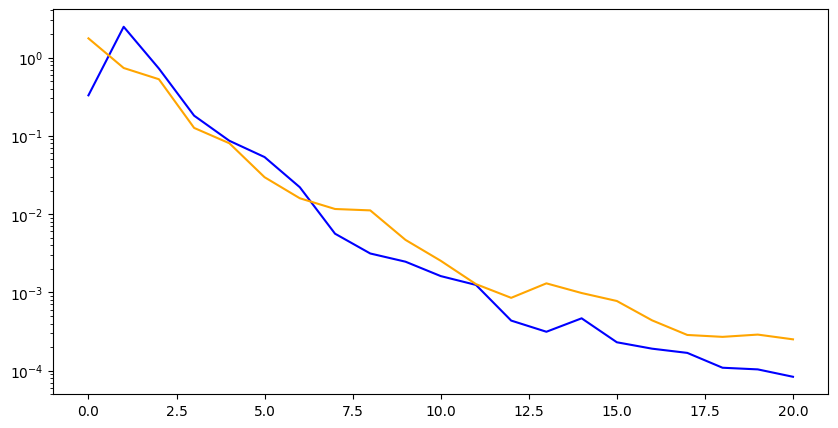

In [84]:
example_isotropic = train_dataloader.dataset.isotropic_data[np.random.randint(0, len(train_dataloader.dataset.isotropic_data))]
example_hotspot = train_dataloader.dataset.hotspot_data[np.random.randint(0, len(train_dataloader.dataset.hotspot_data))]
isotropic_cls = hp.anafast(example_isotropic, lmax=20)
hotspot_cls = hp.anafast(example_hotspot, lmax=20)
plt.figure(figsize=(10, 5))
plt.semilogy(isotropic_cls, label="Isotropic", c='b')
plt.semilogy(hotspot_cls, label="Hotspot", c='orange')

(array([1.0000000e+01, 2.3000000e+01, 6.4000000e+01, 1.6800000e+02,
        4.4500000e+02, 1.0320000e+03, 2.5540000e+03, 6.3670000e+03,
        1.4910000e+04, 3.2537000e+04, 6.8580000e+04, 1.3871900e+05,
        2.7650900e+05, 5.4021100e+05, 1.0520730e+06, 2.1956030e+06,
        6.3930390e+06, 1.8958084e+07, 2.6878510e+07, 2.3969036e+07,
        1.8694730e+07, 1.4085897e+07, 1.0480729e+07, 7.7609920e+06,
        5.7262890e+06, 4.2174070e+06, 3.1040270e+06, 2.2908060e+06,
        1.6895440e+06, 1.2531910e+06, 9.3093400e+05, 6.9399400e+05,
        5.1912900e+05, 3.8843200e+05, 2.9360000e+05, 2.2125000e+05,
        1.6732400e+05, 1.2743000e+05, 9.7334000e+04, 7.4395000e+04,
        5.7028000e+04, 4.3391000e+04, 3.3829000e+04, 2.6019000e+04,
        2.0352000e+04, 1.5669000e+04, 1.2394000e+04, 9.6070000e+03,
        7.5240000e+03, 5.9610000e+03, 4.7080000e+03, 3.5790000e+03,
        2.9090000e+03, 2.2750000e+03, 1.8470000e+03, 1.3960000e+03,
        1.2070000e+03, 9.3800000e+02, 7.5500000e

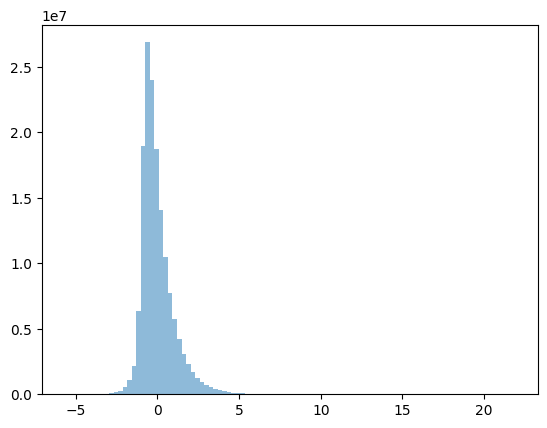

In [85]:
plt.hist(train_dataloader.dataset.isotropic_data.flatten(), bins=100, alpha=0.5, label='Isotropic')

(array([6.000000e+00, 1.500000e+01, 1.800000e+01, 4.900000e+01,
        8.300000e+01, 1.590000e+02, 2.880000e+02, 5.790000e+02,
        1.008000e+03, 1.871000e+03, 3.249000e+03, 5.596000e+03,
        9.718000e+03, 1.616000e+04, 2.721000e+04, 4.512700e+04,
        7.321800e+04, 1.209120e+05, 2.018370e+05, 3.591590e+05,
        7.866910e+05, 2.043886e+06, 3.687416e+06, 4.029670e+06,
        3.500510e+06, 2.873926e+06, 2.319583e+06, 1.857507e+06,
        1.489146e+06, 1.191719e+06, 9.504450e+05, 7.590560e+05,
        6.073580e+05, 4.858820e+05, 3.894850e+05, 3.116990e+05,
        2.510110e+05, 2.021800e+05, 1.623700e+05, 1.317660e+05,
        1.067110e+05, 8.664900e+04, 7.099800e+04, 5.767000e+04,
        4.728900e+04, 3.920700e+04, 3.173000e+04, 2.664200e+04,
        2.143100e+04, 1.792100e+04, 1.483400e+04, 1.237500e+04,
        9.998000e+03, 8.406000e+03, 7.085000e+03, 5.887000e+03,
        4.716000e+03, 4.127000e+03, 3.358000e+03, 2.837000e+03,
        2.376000e+03, 1.952000e+03, 1.60

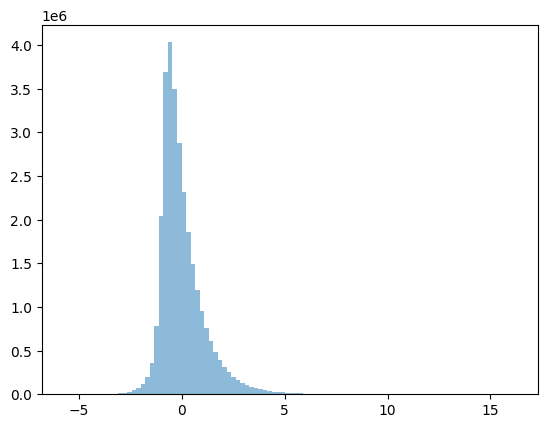

In [10]:
plt.hist(train_dataloader.dataset.hotspot_data[::10].flatten(), bins=100, alpha=0.5, label='Isotropic')

In [86]:
for data, label in train_dataloader:
    print(data)
    print(data.shape)
    print(label)
    break

tensor([[ 5.8556e-01,  3.7372e-01,  2.5472e-01,  ...,  3.5915e-01,
          2.0161e-01, -8.9598e-02],
        [-7.5034e-01, -6.9847e-01, -8.0230e-01,  ...,  9.8538e-02,
          1.2200e-02, -2.2133e-01],
        [ 1.3934e+00,  1.4385e+00,  1.2824e+00,  ...,  1.0295e+00,
          8.9296e-01,  9.1737e-01],
        ...,
        [ 1.8649e+00,  1.9275e+00,  1.7299e+00,  ...,  3.0016e+00,
          2.4432e+00,  2.1550e+00],
        [-2.2520e-02, -1.2611e-01, -2.0131e-01,  ...,  6.0435e-04,
          2.4319e-02, -5.3995e-02],
        [-1.8968e-01, -2.9032e-01, -2.6902e-01,  ...,  2.8315e-02,
         -1.4564e-01, -1.6052e-01]])
torch.Size([32, 768])
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])


In [ ]:
class SimpleSkyMapClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.model(x)).squeeze(1)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   3.,
          1.,   2.,   2.,   3.,   3.,   2.,   1.,   8.,   9.,   5.,  14.,
         20.,  13.,  21.,  26.,  31.,  31.,  48.,  42.,  74.,  61.,  86.,
         73.,  84., 105., 117., 131., 167., 187., 166., 243., 249., 263.,
        219., 256., 265., 287., 306., 320., 301., 341., 319., 310., 348.,
        317., 278., 297., 313., 289., 287., 264., 265., 218., 228., 177.,
        184., 164., 149., 142., 116., 108.,  88.,  90.,  65.,  51.,  60.,
         45.,  48.,  27.,  32.,  24.,  18.,  20.,  13.,   8.,  16.,   9.,
          2.,   5.,   4.,   3.,   2.,   5.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.42554626, 0.42692065, 0.42829505, 0.42966941, 0.4310438 ,
        0.4324182 , 0.43379259, 0.43516698, 0.43654135, 0.43791574,
        0.43929014, 0.44066453, 0.44203889, 0.44341329, 0.44478768,
        0.44616207, 0.44753647, 0.44891083, 0.45028523, 0.45165962,
        0.45303401, 0.45440841, 0.45578277, 0.

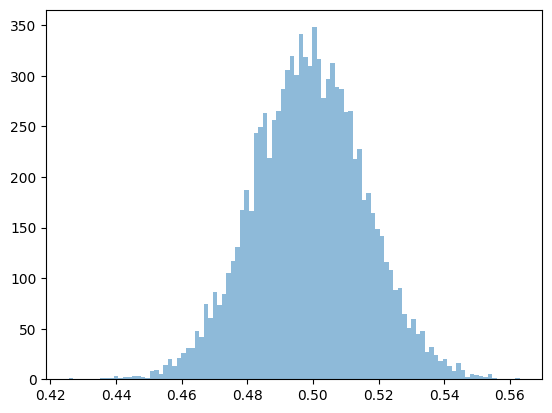

In [88]:
test_model = SimpleSkyMapClassifier(input_dim=train_dataloader.dataset.isotropic_dim)
plt.hist(test_model(torch.randn(10_000, train_dataloader.dataset.isotropic_dim)).detach().numpy(), bins=100, alpha=0.5, label='Isotropic')

In [89]:
def train(model, train_dataloader, val_dataloader, num_epochs=10, learning_rate=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    loss_function = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
    print("Starting training...")
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    try:
        for epoch in range(num_epochs):
            model.train()
            for batch_idx, (maps, labels) in enumerate(train_dataloader):
                maps, labels = maps.to(device), labels.to(device).float()
                optimizer.zero_grad()
                pred_labels = model(maps)
                loss = loss_function(pred_labels, labels)
                loss.backward()
                optimizer.step()

                acc = (pred_labels.round() == labels).float().mean()

                train_losses.append(loss.item())
                train_accuracies.append(acc.item())
                
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}", end='\r')

            model.eval()
            with torch.no_grad():
                val_loss = 0
                val_acc = 0
                for maps, labels in val_dataloader:
                    maps, labels = maps.to(device), labels.to(device).float()
                    pred_labels = model(maps)
                    loss = loss_function(pred_labels, labels)
                    acc = (pred_labels.round() == labels).float().mean()
                    val_loss += loss.item()
                    val_acc += acc.item()

                val_loss /= len(val_dataloader)
                val_losses.append(val_loss)
                val_acc /= len(val_dataloader)
                val_accuracies.append(val_acc)

        print("Training complete.")
        return model, train_losses, train_accuracies, val_losses, val_accuracies

    except KeyboardInterrupt:
        print("Training interrupted. Saving model...")
        return model, train_losses, train_accuracies, val_losses, val_accuracies

In [97]:
input_dim = 768

model = SimpleSkyMapClassifier(input_dim)

trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    learning_rate=1e-3
)

Using device: cpu
Starting training...
Training interrupted. Saving model...6402, Accuracy: 0.625075


Text(0, 0.5, 'Accuracy')

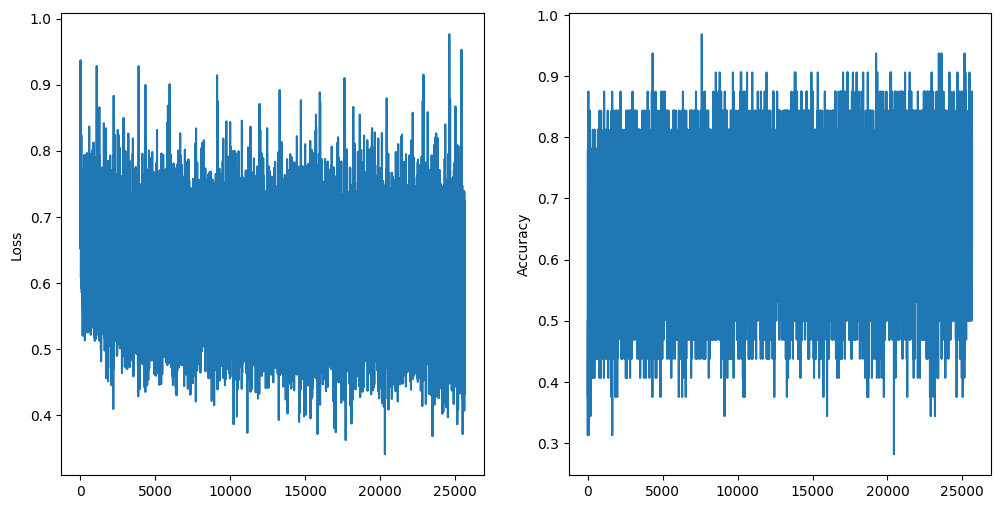

In [98]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.ylabel('Loss')

ax = plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.ylabel('Accuracy')

$\mathcal{L}[f_\phi] = \int{\mathrm{d}x \, p(x | \mathrm{isotropic}) \log \sigma(f_\phi(x))} + p(x | \mathrm{hotspot}) \log[1 - \sigma(f_\phi(x))]$

$= \mathbb{E}_{x \sim p(x | \mathrm{isotropic})}\left[\log \sigma(f_\phi(x))\right] + \mathbb{E}_{x \sim p(x | \mathrm{hotspot})}\left[\log[1 - \sigma(f_\phi(x))]\right]$

$\simeq \frac{1}{N} \sum_{i}{y_i \log \sigma(f_\phi(x_i))} + \frac{1}{N} \sum_{i}{(1 - y_i)\log[1 - \sigma(f_\phi(x))]} $

Point is that if you minimise $\mathcal{L}$ w.r.t. $f_\phi$ then you find that the optimal classifier $f_{\phi^\star}$ is:

$f_{\phi^\star}(x) = \log[ p(x | \mathrm{isotropic}) / p(x | \mathrm{hotspot})]$

In [96]:
import torch
import healpy as hp
import numpy as np
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Step 1: Parameters
# -----------------------------
nside = 8
npix = hp.nside2npix(nside)  # 768
num_maps = 32                # batch size

# -----------------------------
# Step 2: Shared edge index for single graph
# -----------------------------
row, col = [], []
for i in range(npix):
    neighbors = hp.get_all_neighbours(nside, i)
    for n in neighbors:
        if n >= 0:
            row.append(i)
            col.append(n)
edge_index = torch.tensor([row, col], dtype=torch.long)

# -----------------------------
# Step 3: Create batched graph data
# -----------------------------
data_list = []
for _ in range(num_maps):
    x = torch.rand((npix, 1), dtype=torch.float)  # (768, 1)
    data = Data(x=x, edge_index=edge_index)
    data_list.append(data)

batch = Batch.from_data_list(data_list)  # automatic node index shifting

# -----------------------------
# Step 4: Simple GCN model
# -----------------------------
class SimpleGCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)  # from 1D input to 8D hidden
        self.conv2 = GCNConv(16, 768)  # second layer (optional)
        self.compression = nn.Sequential(
            nn.Linear(768, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # final output
        )
        self.sigmoid = nn.Sigmoid()
        self.nside = 8
        self.npix = hp.nside2npix(nside)
        row, col = [], []
        for i in range(self.npix):
            neighbors = hp.get_all_neighbours(nside, i)
            for n in neighbors:
                if n >= 0:
                    row.append(i)
                    col.append(n)
        self.edge_index = torch.tensor([row, col], dtype=torch.long)

    def forward(self, x):
        data_list = []
        for idx in range(x.shape[0]):
            data = Data(x=x[idx, ...].unsqueeze(-1), edge_index=self.edge_index)
            data_list.append(data)
        data_batch = Batch.from_data_list(data_list)
        v, edge_index, batch = data_batch.x, data_batch.edge_index, data_batch.batch
        v = self.conv1(v, edge_index)
        v = F.relu(v)
        v = self.conv2(v, edge_index)
        v = F.relu(v)
        v = global_mean_pool(v, batch)  # [batch_size, features]
        v = self.compression(v)
        v = self.sigmoid(v)
        return v.squeeze(1)

# -----------------------------
# Step 5: Forward pass
# -----------------------------
model = SimpleGCN()
out = model(torch.rand((num_maps, npix), dtype=torch.float))

print(f"Output shape: {out.shape}")  # Should be [10, 4] if num_maps = 10

Output shape: torch.Size([32])


In [97]:
model = SimpleGCN()

trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    learning_rate=1e-4
)

Using device: cpu
Starting training...
Training interrupted. Saving model...6923, Accuracy: 0.5000


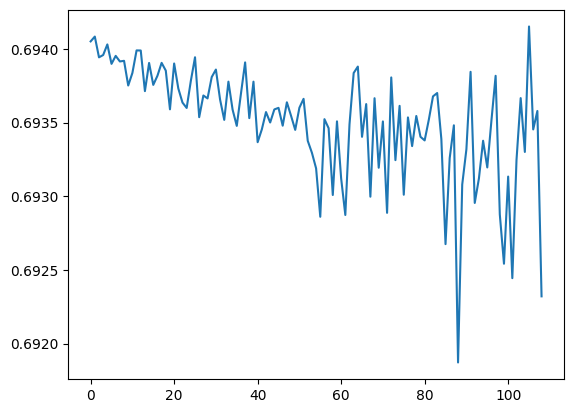

In [100]:
plt.plot(train_losses, label='Loss')
plt.plot(val_losses, label='Validation Loss')

In [101]:
model = SimpleSkyMapClassifier(input_dim=train_dataloader.dataset.isotropic_dim)

trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    learning_rate=1e-3
)

Using device: cpu
Starting training...
Training interrupted. Saving model...0.6010, Accuracy: 0.6562


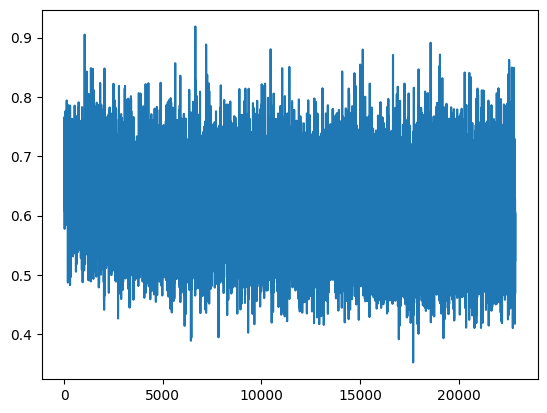

In [ ]:
plt.plot(train_losses, label='Loss')

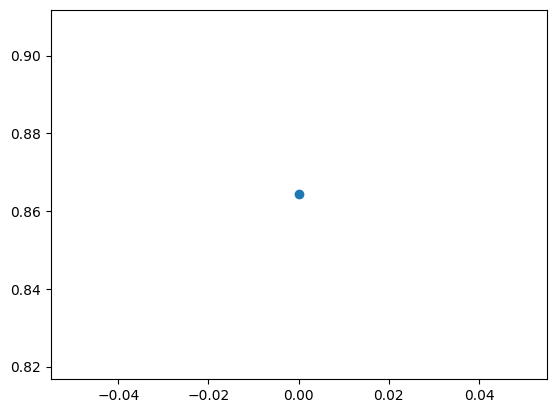

In [104]:
plt.scatter(np.arange(0, len(val_losses)), val_losses, label='Validation Loss')